# iRacing session results analysis

In [28]:
import requests
import json
import urllib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline 

 |->
 Input cell: 
 - enter subsession id and cookie to access session results:

In [29]:
subsession_id = '39625833'
cust_id = '35358774'
cookie = '1572F46017766F674F0F96415BA4C16DCF5296813EBE244EA5AA602407C4CCF47B93C080A411E80DE0DF0D33E09D6956291289557F30676F449BE3B4AA1AC201C93A21822F7CFD012159CC22206DC75908A8C4C8D43E0B6CD51DA5F784EA4AC7672F50A63CB32822A5CBFF61BB474D9A7532D289EEE294F8AC989556CE5C4B73'

Retrieve data from iRacing server:

In [30]:
cookies = {'irsso_membersv2': cookie}
payload = {'subsessionID': subsession_id, 'custid': cust_id }
response = requests.post('https://members.iracing.com/membersite/member/GetSubsessionResults', data=payload, cookies=cookies)

result_json = json.loads(response.text)

Retrieve a list of classes and checks if this is a team race for convenience:

In [31]:
rows = result_json['rows']
classes = []

is_team_race = (result_json['max_team_drivers'] > 1)

for row in rows:
    if row['simsestypename'] != 'Race' or (is_team_race and row['custid'] >= 0):
        continue
    current_class_name = row['ccName'].replace('+', ' ')
    if not current_class_name in classes:
        classes.append(current_class_name)
if is_team_race:
    print('This event is a team race')
else:
    print('This event is a single driver race')
print('Available classes:')
print(classes)

This event is a team race
Available classes:
['LMP1 Class', 'Dallara P217', 'GTE Class']


 |->
 Input cell: 
 - Set class filter if needed (or `None` if no class filtering required)
 - Set the car you want to flatten a gap graph (or `None` to flatten on a leader). Use driver name for single races and team name for team races

In [32]:
class_name = 'Dallara P217'
reference_car = 'Fuga SimSport LMP2 Black'

Retrieve lap time data for each car in a session and pack it to a pandas dataframe 

In [33]:
df = pd.DataFrame(columns = ['Team name', 'Driver name', 'Class name', 'Finish position', 'Class finish position',  'Lap num', 'Lap time', 'Flags'])

maximum_lap_number = 0

driver_ids = {}
for row in rows:
    if row['simsestypename'] != 'Race' or (is_team_race and row['custid'] >= 0):
        continue
    current_class_name = row['ccName'].replace('+', ' ')
    if not class_name is None and current_class_name != class_name:
        continue

    if is_team_race:
        team_name = urllib.parse.unquote(row['displayname'].replace('+', ' '))
    else:
       team_name = '-'

    laps_response = requests.post('https://members.iracing.com/membersite/member/GetLaps?&subsessionid=' + subsession_id + '&groupid=' + str(row['custid']) + "&simsesnum=0", cookies=cookies)
    laps_json = json.loads(laps_response.text)

    drivers = laps_json['drivers']
    for driver in drivers:
        driver_ids[driver['custid']] = urllib.parse.unquote(driver['displayname'].replace('+', ' '))
    prev_lap_sess_time = 0
    laps = laps_json['lapData']
    for lap in laps:
        data = {}
        lap_time = (lap['ses_time'] - prev_lap_sess_time) / 10000.0
        prev_lap_sess_time = lap['ses_time']
        
        data['Team name'] = team_name
        data['Driver name'] = driver_ids[lap['custid']]
        data['Class name'] = current_class_name
        data['Finish position'] = row['finishpos'] + 1
        data['Class finish position'] = row['finishposinclass'] + 1
        data['Lap num'] = lap['lap_num']
        data['Lap time'] = lap_time
        data['Flags'] = lap['flags']

        df = df.append(data, ignore_index=True)

df


,Team name,Driver name,Class name,Finish position,Class finish position,Lap num,Lap time,Flags
0,IPM Cyan,Valter Mendes,Dallara P217,11,1,0,251.3250,0
1,IPM Cyan,Valter Mendes,Dallara P217,11,1,1,232.6413,8192
2,IPM Cyan,Valter Mendes,Dallara P217,11,1,2,212.0998,0
3,IPM Cyan,Valter Mendes,Dallara P217,11,1,3,212.9367,0
4,IPM Cyan,Valter Mendes,Dallara P217,11,1,4,211.2365,0
...,...,...,...,...,...,...,...,...
3523,Penurias Team,Darwin Romero,Dallara P217,43,14,18,217.5207,4
3524,Penurias Team,Darwin Romero,Dallara P217,43,14,19,217.2169,0
3525,Penurias Team,Darwin Romero,Dallara P217,43,14,20,222.4552,0
3526,Penurias Team,Darwin Romero,Dallara P217,43,14,21,365.1210,2


Compute lap time delta from a reference car for each lap:

In [34]:
lap_idxs = list(df['Lap num'].unique())
grouped = df.groupby('Lap num')

deltas = pd.DataFrame(columns = ['Team name', 'Driver name', 'Lap time', 'Delta'])

if reference_car == None:
    if is_team_race:
        reference_car = df.loc[0]['Team name']
    else:
        reference_car = df.loc[0]['Driver name']


for lap_idx in lap_idxs:
    lap_results = grouped.get_group(lap_idx)
    current_leader_time = -1
    for index, row in lap_results.iterrows():    # first let's find the reference car lap time
        if (is_team_race and row['Team name'] == reference_car) or (not is_team_race and row['Driver name'] == reference_car):
            current_leader_time = row['Lap time']
    if current_leader_time > 0:
        current_lap_delta = pd.DataFrame(columns=['Delta'])
        current_lap_delta['Delta'] = lap_results.apply(lambda row: row['Lap time'] - current_leader_time, axis=1)
        deltas = deltas.append(current_lap_delta)

deltas = deltas.filter(['Delta'])
df = df.merge(deltas, how='left', left_index=True, right_index=True)
df

,Team name,Driver name,Class name,Finish position,Class finish position,Lap num,Lap time,Flags,Delta
0,IPM Cyan,Valter Mendes,Dallara P217,11,1,0,251.3250,0,0.0020
1,IPM Cyan,Valter Mendes,Dallara P217,11,1,1,232.6413,8192,-1.2855
2,IPM Cyan,Valter Mendes,Dallara P217,11,1,2,212.0998,0,-0.3606
3,IPM Cyan,Valter Mendes,Dallara P217,11,1,3,212.9367,0,0.5682
4,IPM Cyan,Valter Mendes,Dallara P217,11,1,4,211.2365,0,-1.7162
...,...,...,...,...,...,...,...,...,...
3523,Penurias Team,Darwin Romero,Dallara P217,43,14,18,217.5207,4,4.4931
3524,Penurias Team,Darwin Romero,Dallara P217,43,14,19,217.2169,0,4.3365
3525,Penurias Team,Darwin Romero,Dallara P217,43,14,20,222.4552,0,4.4416
3526,Penurias Team,Darwin Romero,Dallara P217,43,14,21,365.1210,2,94.8363


Compute accumulated gap from a leader car for each car:

In [35]:
if is_team_race:
    car_id_column = 'Team name'
else:
    car_id_column = 'Driver name'
car_ids = list(df[car_id_column].unique())

gaps = pd.DataFrame(columns = ['Delta', 'Gap'])

grouped = df.groupby(car_id_column)
for carId in car_ids:
    car_results = grouped.get_group(carId)
    car_results = car_results.filter(['Delta'])
    gap = 0
    for index, row in car_results.iterrows():
        gap += row['Delta']
        car_results.at[index, 'Gap'] = gap
    gaps = gaps.append(car_results)
gaps = gaps.filter(['Gap'])
df = df.merge(gaps, how='left', left_index=True, right_index=True)
df

,Team name,Driver name,Class name,Finish position,Class finish position,Lap num,Lap time,Flags,Delta,Gap
0,IPM Cyan,Valter Mendes,Dallara P217,11,1,0,251.3250,0,0.0020,0.0020
1,IPM Cyan,Valter Mendes,Dallara P217,11,1,1,232.6413,8192,-1.2855,-1.2835
2,IPM Cyan,Valter Mendes,Dallara P217,11,1,2,212.0998,0,-0.3606,-1.6441
3,IPM Cyan,Valter Mendes,Dallara P217,11,1,3,212.9367,0,0.5682,-1.0759
4,IPM Cyan,Valter Mendes,Dallara P217,11,1,4,211.2365,0,-1.7162,-2.7921
...,...,...,...,...,...,...,...,...,...,...
3523,Penurias Team,Darwin Romero,Dallara P217,43,14,18,217.5207,4,4.4931,141.2281
3524,Penurias Team,Darwin Romero,Dallara P217,43,14,19,217.2169,0,4.3365,145.5646
3525,Penurias Team,Darwin Romero,Dallara P217,43,14,20,222.4552,0,4.4416,150.0062
3526,Penurias Team,Darwin Romero,Dallara P217,43,14,21,365.1210,2,94.8363,244.8425


Basic data is ready, now we can build some nice graphs:

In [36]:
data = []
labels = []

grouped = df.groupby(car_id_column)
for car_id in car_ids:
    labels.append(car_id)
    car_results = grouped.get_group(car_id)
    data.append(car_results['Gap'].values)


Gap graph:

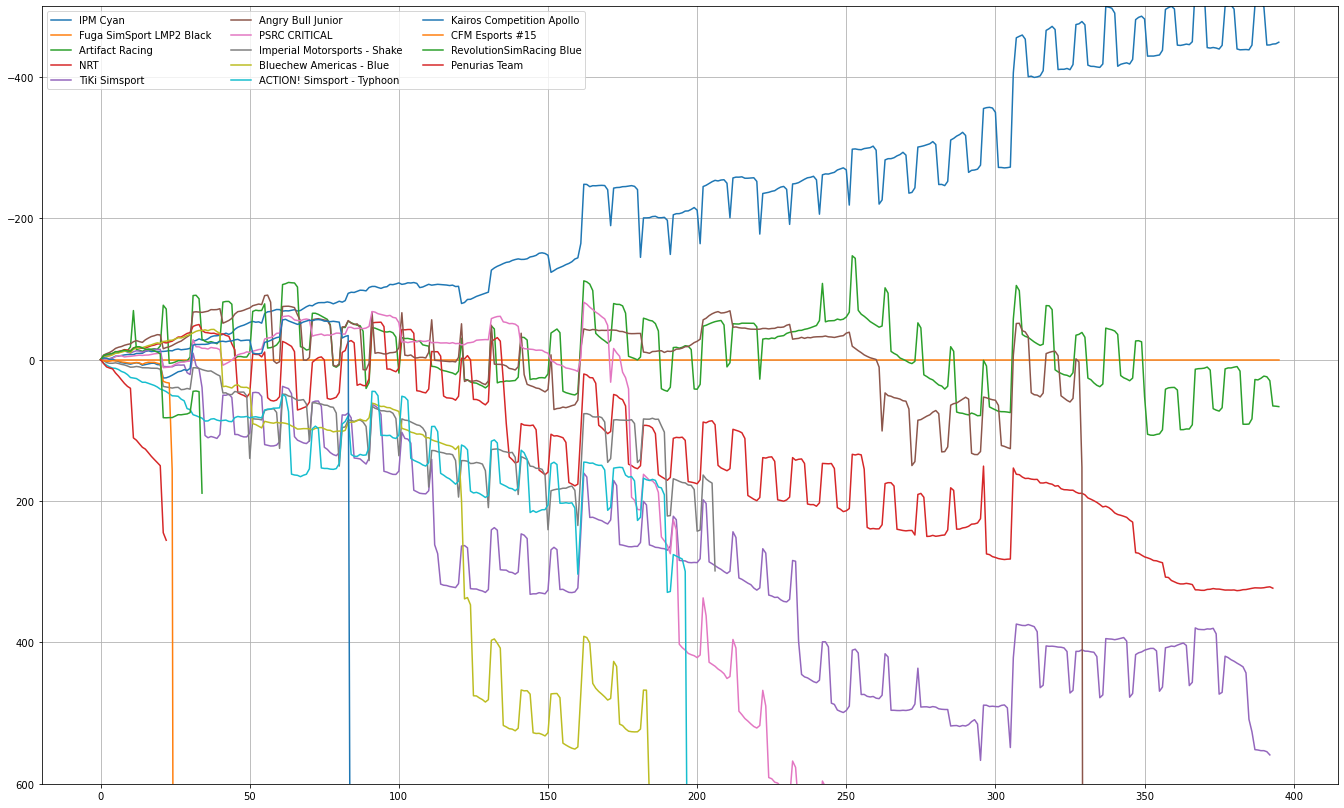

In [37]:
plt.rcParams['figure.figsize'] = [20, 12]

for i, gap in enumerate(data):
    plt.plot(gap, label=labels[i])
plt.legend(ncol=3)
plt.grid(True)
plt.gca().set_ylim([600, -500])
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
plt.show()

 |->
 Input cell: 
 - Set a team to build driver lap times histogram or `None` to build it for all drivers

In [38]:
build_histogram_for = 'Fuga SimSport LMP2 Black'

In [39]:
if build_histogram_for == None:
    if class_name == None:
        drivers = df['Driver name'].unique()
    else:
        drivers = df[df['Class name'] == class_name]['Driver name'].unique()
else:
    drivers = df[df['Team name'] == build_histogram_for]['Driver name'].unique()

lap_times = {}

fastest = 1e+25

for driver in drivers:
    lap_times[driver] = df[df['Driver name'] == driver]['Lap time'].tolist()
    local_fastest = min(lap_times[driver])
    fastest = min(fastest, local_fastest)

for driver in drivers:
    times = lap_times[driver]
    lap_times[driver] = [t for t in times if t <= fastest * 1.03]


driver_names = list(lap_times.keys())
driver_lap_times = list(lap_times.values())

plt.hist(driver_lap_times, label=driver_names)
plt.legend()

plt.show()

NameError: name 'driver_lap_times' is not defined

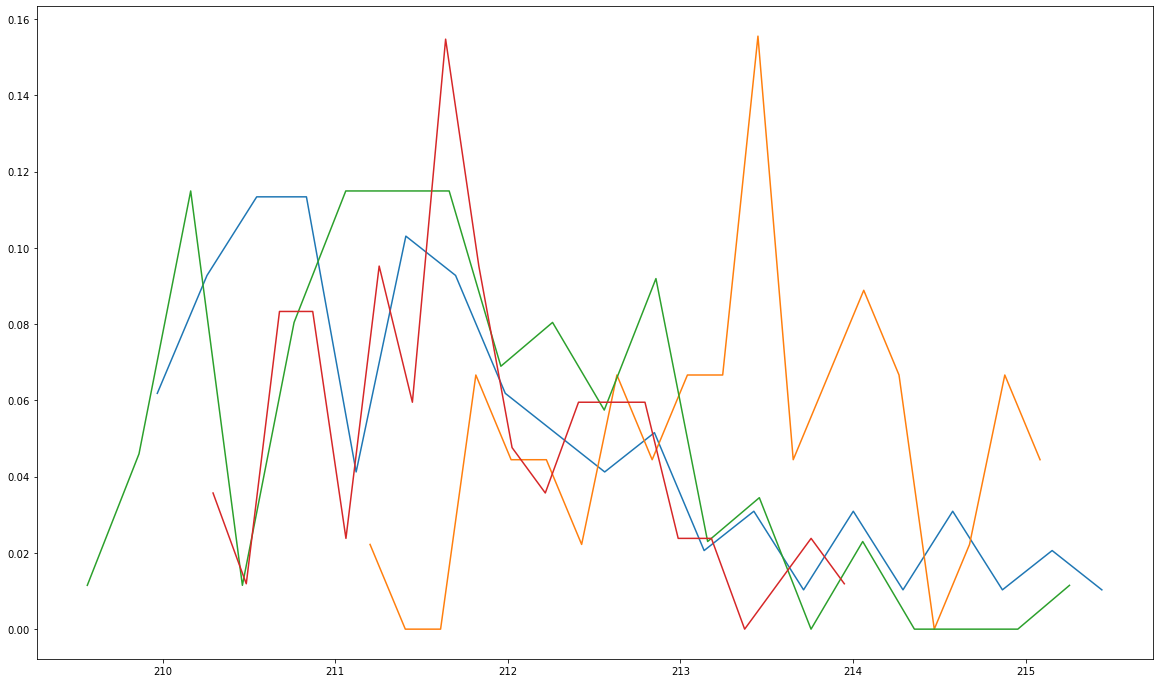

In [ ]:
for driver in drivers:
    data = np.asarray(lap_times[driver])
    y, bin_edges = np.histogram(data, bins=20)
    y = y / len(lap_times[driver])
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    plt.plot(bin_centers, y)

plt.show()


In [ ]:
def seconds_to_lap_time(t):
    minutes = int(t / 60)
    seconds = int(t  - minutes * 60)
    ms = int((t - minutes * 60 - seconds) * 1000)
    return str(minutes) + ":" + str(seconds).zfill(2) + "." + str(ms).zfill(3)

In [ ]:
for driver, times in lap_times.items():
    print('Mean lap time:   ', driver, ': ', seconds_to_lap_time(np.mean(times)))
    print('Median lap time: ', driver, ': ', seconds_to_lap_time(np.median(times)))
    print('Lap time st.dev: ', driver, ': ', round(np.std(times), 3), "s")
    print('Valid laps:      ', driver, ': ', len(times))

Mean lap time:    Luke Pennington :  3:31.748
Median lap time:  Luke Pennington :  3:31.432
Lap time st.dev:  Luke Pennington :  1.382 s
Valid laps:       Luke Pennington :  97
Mean lap time:    Rick Verbiesen :  3:33.362
Median lap time:  Rick Verbiesen :  3:33.416
Lap time st.dev:  Rick Verbiesen :  0.962 s
Valid laps:       Rick Verbiesen :  45
Mean lap time:    Ruslan Bairamkulov :  3:31.618
Median lap time:  Ruslan Bairamkulov :  3:31.535
Lap time st.dev:  Ruslan Bairamkulov :  1.132 s
Valid laps:       Ruslan Bairamkulov :  87
Mean lap time:    Dmitriy Linev :  3:31.772
Median lap time:  Dmitriy Linev :  3:31.644
Lap time st.dev:  Dmitriy Linev :  0.862 s
Valid laps:       Dmitriy Linev :  84
